<a href="https://colab.research.google.com/github/aldiekawahyu/manajerku-inventory-management/blob/main/demand_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Data
Source: https://www.kaggle.com/felixzhao/productdemandforecasting \\
Steps:
1. Go to kaggle account and click **'Create New API Token'**. A kaggle.json file will be downloaded to your local machine.
1. Upload the kaggle.json file into into colab
1. Download the dataset from kaggle and unzip it

In [ ]:
import os

! pip install -q kaggle
from google.colab import files
files.upload()
try:
  os.makedirs('~/.kaggle')    
  print('Directory created successfully')
except:
  pass
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d felixzhao/productdemandforecasting/
! unzip productdemandforecasting.zip

Saving kaggle.json to kaggle.json
  0% 0.00/5.02M [00:00<?, ?B/s]
100% 5.02M/5.02M [00:00<00:00, 46.1MB/s]
Archive:  productdemandforecasting.zip
  inflating: Historical Product Demand.csv  


# EDA and Data Preprocessing

## Check Missing Value and Object Type

First, open the csv file as pandas dataframe file then check if there are missing values.

In [ ]:
import pandas as pd

df = pd.read_csv('Historical Product Demand.csv')
print('Dataframe length: {}'.format(len(df)))
df.head()

Dataframe length: 1048575


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


Check the number of missing value per column.

In [ ]:
df.isnull().sum()

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

Proportion of missing value per column.

In [ ]:
df.isnull().sum()/len(df)

Product_Code        0.000000
Warehouse           0.000000
Product_Category    0.000000
Date                0.010718
Order_Demand        0.000000
dtype: float64

It can be seen that there are missing values in *Date* column. We are going to handle this by **dropping rows containing missing value**, because date is non-numerical value thus it cannot be imputed.

In [ ]:
print('Length before dropping: {}'.format(len(df)))
df = df.dropna(axis='rows')
print('Length after dropping: {}'.format(len(df)))

Length before dropping: 1048575
Length after dropping: 1037336


Next, we will check the type of each column of the data frame and convert the type of *Order_Demand* column if it is non-numeric.

In [ ]:
df.dtypes

Product_Code        object
Warehouse           object
Product_Category    object
Date                object
Order_Demand        object
dtype: object

We see that *Order_Demand* column is not a float, so there must be something about the number. Let's try to convert it into float.

In [ ]:
try:
  df["Order_Demand"] = pd.to_numeric(df["Order_Demand"], downcast="float")
  print('Conversion succeeded')
except ValueError as e:
  print('Cannot do conversion: ',e)

Cannot do conversion:  Unable to parse string "(1)" at position 112289


We see an indication that several numbers in *Order_Demand* column are written in parentheses, so we need to remove the parentheses.

In [ ]:
def remove_parentheses(x):
  import re
  return re.sub('[()]', '', x)

df["Order_Demand"] = df["Order_Demand"].apply(remove_parentheses)

Lets try doing conversion again.

In [ ]:
try:
  df["Order_Demand"] = pd.to_numeric(df["Order_Demand"], downcast="float")
  print('Conversion succeeded')
except ValueError as e:
  print('Cannot do conversion: ',e)

df.dtypes

Conversion succeeded


Product_Code         object
Warehouse            object
Product_Category     object
Date                 object
Order_Demand        float32
dtype: object

The *Order_Demand* column is already converted to float. Next we are going to convert *Date* column to datetime.

In [ ]:
df.Date = pd.to_datetime(df.Date)
df.dtypes

Product_Code                object
Warehouse                   object
Product_Category            object
Date                datetime64[ns]
Order_Demand               float32
dtype: object

In [ ]:
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100.0
1,Product_0979,Whse_J,Category_028,2012-01-19,500.0
2,Product_0979,Whse_J,Category_028,2012-02-03,500.0
3,Product_0979,Whse_J,Category_028,2012-02-09,500.0
4,Product_0979,Whse_J,Category_028,2012-03-02,500.0


The *Date* column is already converted to datetime.

## Get Unique Value of *Product_Code*,	*Warehouse* and	*Product_Category*

In [ ]:
# Products
product_code = sorted(df['Product_Code'].unique().tolist())
number_of_product = len(product_code)
print('Number of product: {}'.format(number_of_product))

# Warehouses
warehouse = sorted(df['Warehouse'].unique().tolist())
number_of_warehouse = len(warehouse)
print('Number of warehouse: {}'.format(number_of_warehouse))

# Product category
product_category = sorted(df['Product_Category'].unique().tolist())
number_of_product_category = len(product_category)
print('Number of product category: {}'.format(number_of_product_category))

Number of product: 2160
Number of warehouse: 4
Number of product category: 33


## Check Total Number of Product per Category

In [ ]:
sample = 10
product_per_category = df.groupby(['Product_Category'])['Product_Code'].nunique()
print("Total number of product per each category for first {} category \n{}".format(sample, product_per_category[:sample]))

Total number of product per each category for first 10 category 
Product_Category
Category_001    278
Category_002      1
Category_003     12
Category_004      1
Category_005    185
Category_006    112
Category_007    141
Category_008      7
Category_009    102
Category_010      7
Name: Product_Code, dtype: int64


## Check Total Date (or days) per Product

In [ ]:
days_per_product = df.groupby(['Product_Code'])['Date'].nunique()
print("Total number of days per product: \n{}".format(days_per_product))

Total number of days per product: 
Product_Code
Product_0001    469
Product_0002    341
Product_0003    275
Product_0004    267
Product_0005     52
               ... 
Product_2168    647
Product_2169    571
Product_2170    173
Product_2171    509
Product_2172     46
Name: Date, Length: 2160, dtype: int64


We can see that each product has a different amount of record.

## Inspect the Demand Aggregate of Each Product Category

In [ ]:
df.groupby(["Product_Category", "Product_Code"]).agg({"Order_Demand": ["sum", "mean", "median", "std"]})

Order_Demand                                     
                                       sum          mean   median           std
Product_Category Product_Code                                                  
Category_001     Product_0256        371.0      1.641593      1.0      1.493644
                 Product_0257        177.0      1.638889      1.0      0.999611
                 Product_0258        298.0      2.083916      2.0      1.859488
                 Product_0259        205.0      2.277778      2.0      1.735471
                 Product_0260       1729.0     11.761905      3.0     16.716546
...                                    ...           ...      ...           ...
Category_032     Product_1101    3394000.0  14082.987305  10000.0  17006.658040
Category_033     Product_1282    9710000.0  21108.695312  20000.0  15091.194479
                 Product_1361   28190000.0  29334.027344  10000.0  35133.284570
                 Product_1362    1290000.0  10000.000000  10000.0   1250.000000
                 Product_1363    3420000.0  11438.126953  10000.0   7254.159962

[2160 rows x 4 columns]

## Sort Data based on the Date

In [ ]:
df = df.sort_values(by="Date")
print('Dataframe length: {}'.format(len(df)))
df.head()

Dataframe length: 1037336


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
44799,Product_0965,Whse_A,Category_006,2011-01-08,2.0
72252,Product_1724,Whse_A,Category_003,2011-05-31,108.0
8431,Product_1521,Whse_S,Category_019,2011-06-24,85000.0
8432,Product_1521,Whse_S,Category_019,2011-06-24,7000.0
72669,Product_1507,Whse_C,Category_019,2011-09-02,1250.0


Check behavior of the date.

In [ ]:
df.Date.unique()[:50]

array(['2011-01-08T00:00:00.000000000', '2011-05-31T00:00:00.000000000',
       '2011-06-24T00:00:00.000000000', '2011-09-02T00:00:00.000000000',
       '2011-09-27T00:00:00.000000000', '2011-09-30T00:00:00.000000000',
       '2011-10-20T00:00:00.000000000', '2011-10-31T00:00:00.000000000',
       '2011-11-04T00:00:00.000000000', '2011-11-18T00:00:00.000000000',
       '2011-11-21T00:00:00.000000000', '2011-11-22T00:00:00.000000000',
       '2011-11-23T00:00:00.000000000', '2011-11-24T00:00:00.000000000',
       '2011-11-25T00:00:00.000000000', '2011-11-28T00:00:00.000000000',
       '2011-11-29T00:00:00.000000000', '2011-11-30T00:00:00.000000000',
       '2011-12-01T00:00:00.000000000', '2011-12-02T00:00:00.000000000',
       '2011-12-05T00:00:00.000000000', '2011-12-06T00:00:00.000000000',
       '2011-12-07T00:00:00.000000000', '2011-12-08T00:00:00.000000000',
       '2011-12-09T00:00:00.000000000', '2011-12-12T00:00:00.000000000',
       '2011-12-13T00:00:00.000000000', '2011-12-14

We see that the records for 2011 are too few (so many missing dates). So we took data starting from January 2012 and later fill missing dates with zero.

In [ ]:
df = df.loc[df.Date.dt.year >= 2012, :]
print('Dataframe length: {}'.format(len(df)))
df.head()

Dataframe length: 1036696


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
130870,Product_2166,Whse_S,Category_024,2012-01-01,2.0
75478,Product_0288,Whse_S,Category_021,2012-01-02,100.0
197183,Product_0595,Whse_S,Category_032,2012-01-02,42.0
130772,Product_1195,Whse_S,Category_019,2012-01-02,5000.0
75479,Product_1817,Whse_S,Category_006,2012-01-02,2500.0


In [ ]:
df.Date.unique()[:20]

array(['2012-01-01T00:00:00.000000000', '2012-01-02T00:00:00.000000000',
       '2012-01-03T00:00:00.000000000', '2012-01-04T00:00:00.000000000',
       '2012-01-05T00:00:00.000000000', '2012-01-06T00:00:00.000000000',
       '2012-01-08T00:00:00.000000000', '2012-01-09T00:00:00.000000000',
       '2012-01-10T00:00:00.000000000', '2012-01-11T00:00:00.000000000',
       '2012-01-12T00:00:00.000000000', '2012-01-13T00:00:00.000000000',
       '2012-01-15T00:00:00.000000000', '2012-01-16T00:00:00.000000000',
       '2012-01-17T00:00:00.000000000', '2012-01-18T00:00:00.000000000',
       '2012-01-19T00:00:00.000000000', '2012-01-20T00:00:00.000000000',
       '2012-01-21T00:00:00.000000000', '2012-01-22T00:00:00.000000000'],
      dtype='datetime64[ns]')

## Pivot Table

In [ ]:
import numpy as np
df_pivot = pd.pivot_table(df, values=['Order_Demand'], index=['Date'],
                    columns=['Product_Code', 'Warehouse'], aggfunc=np.sum).fillna(0)
df_pivot.head()

Order_Demand         ...                          
Product_Code Product_0001         ... Product_2171 Product_2172
Warehouse          Whse_A Whse_J  ...       Whse_J       Whse_J
Date                              ...                          
2012-01-01            0.0    0.0  ...          0.0          0.0
2012-01-02            0.0    0.0  ...          0.0          0.0
2012-01-03         1000.0    0.0  ...          0.0          0.0
2012-01-04          200.0    0.0  ...          0.0          0.0
2012-01-05            0.0  100.0  ...          0.0          0.0

[5 rows x 2849 columns]

## **Feature Dataframe**

In [ ]:
df_feature = pd.DataFrame(index=df_pivot.index)
for colnames in df_pivot.columns:
  df_feature['{}_{}_Demand'.format(colnames[1], colnames[2])] = df_pivot[colnames[0], colnames[1], colnames[2]]

We are going to **fill missing dates** (dates with no records) in *df_feature* with zero for every column.

In [ ]:
df_feature = df_feature.asfreq('D').fillna(0)
df_feature

,Product_0001_Whse_A_Demand,Product_0001_Whse_J_Demand,Product_0002_Whse_C_Demand,Product_0002_Whse_S_Demand,Product_0003_Whse_J_Demand,Product_0003_Whse_S_Demand,Product_0004_Whse_J_Demand,Product_0005_Whse_J_Demand,Product_0006_Whse_J_Demand,Product_0007_Whse_J_Demand,Product_0008_Whse_C_Demand,Product_0008_Whse_J_Demand,Product_0009_Whse_J_Demand,Product_0010_Whse_J_Demand,Product_0011_Whse_J_Demand,Product_0012_Whse_C_Demand,Product_0012_Whse_J_Demand,Product_0012_Whse_S_Demand,Product_0013_Whse_J_Demand,Product_0014_Whse_J_Demand,Product_0015_Whse_J_Demand,Product_0016_Whse_J_Demand,Product_0017_Whse_J_Demand,Product_0018_Whse_J_Demand,Product_0019_Whse_J_Demand,Product_0020_Whse_A_Demand,Product_0020_Whse_J_Demand,Product_0021_Whse_C_Demand,Product_0021_Whse_J_Demand,Product_0021_Whse_S_Demand,Product_0022_Whse_J_Demand,Product_0023_Whse_J_Demand,Product_0024_Whse_J_Demand,Product_0025_Whse_J_Demand,Product_0026_Whse_J_Demand,Product_0027_Whse_J_Demand,Product_0028_Whse_J_Demand,Product_0029_Whse_J_Demand,Product_0030_Whse_J_Demand,Product_0031_Whse_A_Demand,...,Product_2153_Whse_J_Demand,Product_2153_Whse_S_Demand,Product_2154_Whse_J_Demand,Product_2154_Whse_S_Demand,Product_2155_Whse_J_Demand,Product_2155_Whse_S_Demand,Product_2156_Whse_S_Demand,Product_2157_Whse_J_Demand,Product_2157_Whse_S_Demand,Product_2158_Whse_J_Demand,Product_2158_Whse_S_Demand,Product_2159_Whse_J_Demand,Product_2159_Whse_S_Demand,Product_2160_Whse_J_Demand,Product_2160_Whse_S_Demand,Product_2161_Whse_S_Demand,Product_2162_Whse_S_Demand,Product_2163_Whse_J_Demand,Product_2164_Whse_A_Demand,Product_2165_Whse_A_Demand,Product_2165_Whse_C_Demand,Product_2165_Whse_S_Demand,Product_2166_Whse_A_Demand,Product_2166_Whse_C_Demand,Product_2166_Whse_J_Demand,Product_2166_Whse_S_Demand,Product_2167_Whse_A_Demand,Product_2167_Whse_C_Demand,Product_2167_Whse_J_Demand,Product_2167_Whse_S_Demand,Product_2168_Whse_A_Demand,Product_2168_Whse_J_Demand,Product_2168_Whse_S_Demand,Product_2169_Whse_A_Demand,Product_2169_Whse_C_Demand,Product_2169_Whse_J_Demand,Product_2169_Whse_S_Demand,Product_2170_Whse_C_Demand,Product_2171_Whse_J_Demand,Product_2172_Whse_J_Demand
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,0.0,0.0,0.0
2012-01-03,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,0.0,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-04,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,390.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0
2012-01-05,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3000.0,0.0,0.0,1400.0,0.0,1000.0,10000.0,0.0,0.0,1000.0,100.0,200.0,100.0,0.0,0.0,1100.0,500.0,0.0,0.0,0.0,0.0,0.0,1600.0,0.0,50.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,11.0,0.0,17.0,30.0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,.

Next we are going to append the dataframe for the prediction

In [ ]:
from datetime import datetime, timedelta
first_date = df_feature.index.min()
last_date = df_feature.index.max()
prediction_period = 30

df_prediction = pd.DataFrame(index=pd.date_range(last_date + timedelta(days=1), periods=prediction_period))
for colnames in df_feature.columns:
  df_prediction[colnames] = np.zeros(df_prediction.shape[0])

Next, concat the dataframe.

In [ ]:
df_feature = pd.concat([df_feature, df_prediction])

In [ ]:
product_warehouse_list = df_feature.columns
product_warehouse_list

Index(['Product_0001_Whse_A_Demand', 'Product_0001_Whse_J_Demand',
       'Product_0002_Whse_C_Demand', 'Product_0002_Whse_S_Demand',
       'Product_0003_Whse_J_Demand', 'Product_0003_Whse_S_Demand',
       'Product_0004_Whse_J_Demand', 'Product_0005_Whse_J_Demand',
       'Product_0006_Whse_J_Demand', 'Product_0007_Whse_J_Demand',
       ...
       'Product_2168_Whse_A_Demand', 'Product_2168_Whse_J_Demand',
       'Product_2168_Whse_S_Demand', 'Product_2169_Whse_A_Demand',
       'Product_2169_Whse_C_Demand', 'Product_2169_Whse_J_Demand',
       'Product_2169_Whse_S_Demand', 'Product_2170_Whse_C_Demand',
       'Product_2171_Whse_J_Demand', 'Product_2172_Whse_J_Demand'],
      dtype='object', length=2849)

In [ ]:
# df_pivot.to_csv('Demand_per_product_per_warehouse.csv')

## Time Series Plot

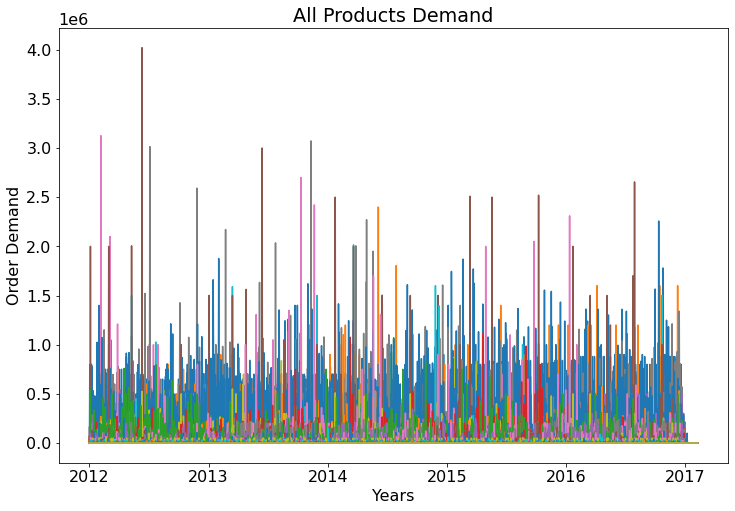

In [ ]:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

fig,ax = plt.subplots(figsize=(12,8))
for column in df_feature:
    plt.plot(df_feature.index, df_feature[column])
ax.set_title('All Products Demand')
ax.set_xlabel('Years')
ax.set_ylabel('Order Demand')
plt.show()

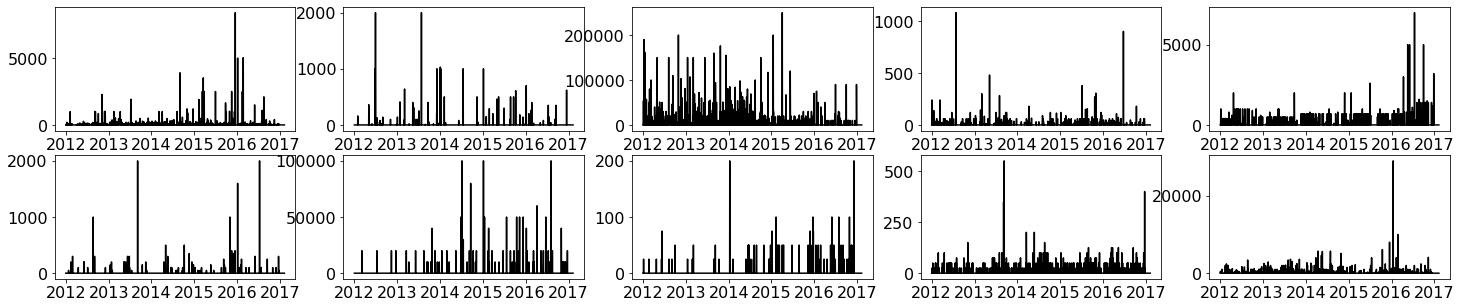

In [ ]:
# Randomly choose 10 series and plot them
nrows = 2
ncols = 5
fig, ax = plt.subplots(nrows, ncols, figsize=(25,5))
for i in range(nrows):
  for j in range(ncols):
    ax[i,j].plot(df_feature.index, df_feature.sample(axis='columns').values, c='black')
plt.show()

It can be seen that some series are 'normal' time series, and some others are like impulses.

## One Hot Encoding for Time Units

In [ ]:
df_weekday = pd.get_dummies(df_feature.index.weekday, prefix='Weekday')
df_weekday.index = df_feature.index
df_weekday.head()

,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
2012-01-01,0,0,0,0,0,0,1
2012-01-02,1,0,0,0,0,0,0
2012-01-03,0,1,0,0,0,0,0
2012-01-04,0,0,1,0,0,0,0
2012-01-05,0,0,0,1,0,0,0


In [ ]:
df_month = pd.get_dummies(df_feature.index.month, prefix='Month')
df_month.index =  df_feature.index
df_month.head()

,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
2012-01-01,1,0,0,0,0,0,0,0,0,0,0,0
2012-01-02,1,0,0,0,0,0,0,0,0,0,0,0
2012-01-03,1,0,0,0,0,0,0,0,0,0,0,0
2012-01-04,1,0,0,0,0,0,0,0,0,0,0,0
2012-01-05,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_feature = pd.concat([df_weekday, df_month, df_feature], axis=1)
df_feature.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1866 entries, 2012-01-01 to 2017-02-08
Freq: D
Columns: 2868 entries, Weekday_0 to Product_2172_Whse_J_Demand
dtypes: float64(2849), uint8(19)
memory usage: 40.6 MB


In [ ]:
df_feature

,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Product_0001_Whse_A_Demand,Product_0001_Whse_J_Demand,Product_0002_Whse_C_Demand,Product_0002_Whse_S_Demand,Product_0003_Whse_J_Demand,Product_0003_Whse_S_Demand,Product_0004_Whse_J_Demand,Product_0005_Whse_J_Demand,Product_0006_Whse_J_Demand,Product_0007_Whse_J_Demand,Product_0008_Whse_C_Demand,Product_0008_Whse_J_Demand,Product_0009_Whse_J_Demand,Product_0010_Whse_J_Demand,Product_0011_Whse_J_Demand,Product_0012_Whse_C_Demand,Product_0012_Whse_J_Demand,Product_0012_Whse_S_Demand,Product_0013_Whse_J_Demand,Product_0014_Whse_J_Demand,Product_0015_Whse_J_Demand,...,Product_2153_Whse_J_Demand,Product_2153_Whse_S_Demand,Product_2154_Whse_J_Demand,Product_2154_Whse_S_Demand,Product_2155_Whse_J_Demand,Product_2155_Whse_S_Demand,Product_2156_Whse_S_Demand,Product_2157_Whse_J_Demand,Product_2157_Whse_S_Demand,Product_2158_Whse_J_Demand,Product_2158_Whse_S_Demand,Product_2159_Whse_J_Demand,Product_2159_Whse_S_Demand,Product_2160_Whse_J_Demand,Product_2160_Whse_S_Demand,Product_2161_Whse_S_Demand,Product_2162_Whse_S_Demand,Product_2163_Whse_J_Demand,Product_2164_Whse_A_Demand,Product_2165_Whse_A_Demand,Product_2165_Whse_C_Demand,Product_2165_Whse_S_Demand,Product_2166_Whse_A_Demand,Product_2166_Whse_C_Demand,Product_2166_Whse_J_Demand,Product_2166_Whse_S_Demand,Product_2167_Whse_A_Demand,Product_2167_Whse_C_Demand,Product_2167_Whse_J_Demand,Product_2167_Whse_S_Demand,Product_2168_Whse_A_Demand,Product_2168_Whse_J_Demand,Product_2168_Whse_S_Demand,Product_2169_Whse_A_Demand,Product_2169_Whse_C_Demand,Product_2169_Whse_J_Demand,Product_2169_Whse_S_Demand,Product_2170_Whse_C_Demand,Product_2171_Whse_J_Demand,Product_2172_Whse_J_Demand
2012-01-01,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-02,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,0.0,0.0,0.0
2012-01-03,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-04,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,390.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0
2012-01-05,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3000.0,0.0,0.0,1400.0,0.0,1000.0,10000.0,0.0,0.0,1000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,11.0,0.0,17.0,30.0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-04,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-02-05,0,0,0,0,0,0,1,0,1,0,

## Train Test Split

In [ ]:
train_size = len(df_feature) - prediction_period
df_train = df_feature.iloc[:train_size].copy()
df_train['Is_train'] = np.repeat(True, df_train.shape[0])

df_test = df_feature.iloc[-prediction_period:].copy()
df_test['Is_train'] = np.repeat(False, df_test.shape[0])


df_feature = pd.concat([df_train, df_test])

## Shift Demand

In [ ]:
def shift_series(series, days):
    return series.transform(lambda x: x.shift(days))

def shift_series_in_df(df, days_delta, series_names=[]):
    shifted = pd.DataFrame(index=df.index.copy())
    sign = 'Future' if np.sign(days_delta) < 0 else 'Past'
    for series_name in series_names:
        shifted['{}_{}_{}'.format(series_name,sign,np.abs(days_delta))] = \
          shift_series(df[series_name], days_delta)
    return shifted
    
def stack_shifted_sales(df, days_delta=90):
    names = product_warehouse_list
    dfs = [df.copy()]
    abs_range = range(1, days_delta+1) if days_delta > 0 else range(days_delta, 0)
    for day_offset in abs_range:
        delta = -day_offset
        shifted = shift_series_in_df(df, series_names=names, days_delta=delta)
        dfs.append(shifted)
    return pd.concat(dfs, axis=1, copy=False)

In [ ]:
df_feature_shifted = stack_shifted_sales(df_feature, days_delta=-1)
df_feature_shifted = df_feature_shifted.dropna()
df_feature_shifted

,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Product_0001_Whse_A_Demand,Product_0001_Whse_J_Demand,Product_0002_Whse_C_Demand,Product_0002_Whse_S_Demand,Product_0003_Whse_J_Demand,Product_0003_Whse_S_Demand,Product_0004_Whse_J_Demand,Product_0005_Whse_J_Demand,Product_0006_Whse_J_Demand,Product_0007_Whse_J_Demand,Product_0008_Whse_C_Demand,Product_0008_Whse_J_Demand,Product_0009_Whse_J_Demand,Product_0010_Whse_J_Demand,Product_0011_Whse_J_Demand,Product_0012_Whse_C_Demand,Product_0012_Whse_J_Demand,Product_0012_Whse_S_Demand,Product_0013_Whse_J_Demand,Product_0014_Whse_J_Demand,Product_0015_Whse_J_Demand,...,Product_2153_Whse_J_Demand_Past_1,Product_2153_Whse_S_Demand_Past_1,Product_2154_Whse_J_Demand_Past_1,Product_2154_Whse_S_Demand_Past_1,Product_2155_Whse_J_Demand_Past_1,Product_2155_Whse_S_Demand_Past_1,Product_2156_Whse_S_Demand_Past_1,Product_2157_Whse_J_Demand_Past_1,Product_2157_Whse_S_Demand_Past_1,Product_2158_Whse_J_Demand_Past_1,Product_2158_Whse_S_Demand_Past_1,Product_2159_Whse_J_Demand_Past_1,Product_2159_Whse_S_Demand_Past_1,Product_2160_Whse_J_Demand_Past_1,Product_2160_Whse_S_Demand_Past_1,Product_2161_Whse_S_Demand_Past_1,Product_2162_Whse_S_Demand_Past_1,Product_2163_Whse_J_Demand_Past_1,Product_2164_Whse_A_Demand_Past_1,Product_2165_Whse_A_Demand_Past_1,Product_2165_Whse_C_Demand_Past_1,Product_2165_Whse_S_Demand_Past_1,Product_2166_Whse_A_Demand_Past_1,Product_2166_Whse_C_Demand_Past_1,Product_2166_Whse_J_Demand_Past_1,Product_2166_Whse_S_Demand_Past_1,Product_2167_Whse_A_Demand_Past_1,Product_2167_Whse_C_Demand_Past_1,Product_2167_Whse_J_Demand_Past_1,Product_2167_Whse_S_Demand_Past_1,Product_2168_Whse_A_Demand_Past_1,Product_2168_Whse_J_Demand_Past_1,Product_2168_Whse_S_Demand_Past_1,Product_2169_Whse_A_Demand_Past_1,Product_2169_Whse_C_Demand_Past_1,Product_2169_Whse_J_Demand_Past_1,Product_2169_Whse_S_Demand_Past_1,Product_2170_Whse_C_Demand_Past_1,Product_2171_Whse_J_Demand_Past_1,Product_2172_Whse_J_Demand_Past_1
2012-01-02,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-03,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,0.0,0.0,0.0
2012-01-04,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-05,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3000.0,0.0,0.0,1400.0,0.0,1000.0,10000.0,0.0,0.0,1000.0,...,0.0,0.0,0.0,390.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0
2012-01-06,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,100.0,0.0,1400.0,0.0,0.0,0.0,100.0,1000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,11.0,0.0,17.0,30.0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-04,0,0,0,0,0,1,0,0,1,0,0,0,0

We are going to make sure stacked and standard demand columns appear in the same order.

In [ ]:
demand_columns = [column for column in df_feature.columns if '_Demand' in column and '_Demand_' not in column]
stacked_demand_columns = [column for column in df_feature.columns if '_Demand_' in column]
other_columns = [column for column in df_feature.columns if column not in set(demand_columns) and column not in set(stacked_demand_columns)]

demand_columns = sorted(demand_columns)
stacked_demand_columns = sorted(stacked_demand_columns)

new_columns = other_columns + stacked_demand_columns + demand_columns

In [ ]:
df_feature_shifted = df_feature_shifted.reindex(columns=new_columns)

In [ ]:
assert df_feature_shifted.isna().any().any() == False

In [ ]:
# df_feature_shifted.to_csv('df_feature_shifted.csv')

## Get Training and Validation Dataframe

In [ ]:
df_train = df_feature_shifted[df_feature_shifted['Is_train'] == True].drop('Is_train', axis=1)
df_test = df_feature_shifted[df_feature_shifted['Is_train'] == False].drop('Is_train', axis=1)

Next we are going to extract the "X" and "y" for training

In [ ]:
X_columns_stacked = [column for column in df_train.columns if '_Past_' in column]
X_columns_caldata = [column for column in df_train.columns if 'Weekday' in column or 'Month' in column]
X_columns = X_columns_stacked + X_columns_caldata

X = df_train[X_columns]

In [ ]:
X_colset = set(X_columns)
y_columns = [column for column in df_train.columns if column not in X_colset]

y = df_train[y_columns]

Train test split

In [ ]:
test_size = 0.2
training_size = 1 - test_size

X_train = X.iloc[:int(training_size*len(X))].copy()
X_valid = X.iloc[int(training_size*len(X)):].copy()
y_train = y.iloc[:int(training_size*len(y))].copy()
y_valid = y.iloc[int(training_size*len(y)):].copy()

Reshaping the variable for multivariate time series training.

In [ ]:
X_train_vals = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid_vals = X_valid.values.reshape((X_valid.shape[0], 1, X_valid.shape[1]))

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1835 entries, 2012-01-02 to 2017-01-09
Freq: D
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Weekday_0  1835 non-null   uint8
 1   Weekday_1  1835 non-null   uint8
 2   Weekday_2  1835 non-null   uint8
 3   Weekday_3  1835 non-null   uint8
 4   Weekday_4  1835 non-null   uint8
 5   Weekday_5  1835 non-null   uint8
 6   Weekday_6  1835 non-null   uint8
 7   Month_1    1835 non-null   uint8
 8   Month_2    1835 non-null   uint8
 9   Month_3    1835 non-null   uint8
 10  Month_4    1835 non-null   uint8
 11  Month_5    1835 non-null   uint8
 12  Month_6    1835 non-null   uint8
 13  Month_7    1835 non-null   uint8
 14  Month_8    1835 non-null   uint8
 15  Month_9    1835 non-null   uint8
 16  Month_10   1835 non-null   uint8
 17  Month_11   1835 non-null   uint8
 18  Month_12   1835 non-null   uint8
dtypes: uint8(19)
memory usage: 48.4 KB


In [ ]:
len(y.columns)

2849

# Modeling and Forecasting

## Define the Model

In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(
      filters=len(y.columns), kernel_size=5,
      strides=1, padding="causal",
      activation="relu",
      input_shape=(X_train_vals.shape[1], X_train_vals.shape[2])),
  # tf.keras.layers.Conv1D(
  #     len(y.columns),
  #     kernel_size=5,
  #     padding='same',
  #     activation='relu'),
  tf.keras.layers.AvgPool1D(
      pool_size=5,
      padding='same'),
  tf.keras.layers.LSTM(len(y.columns), return_sequences=True),
  # tf.keras.layers.LSTM(len(y.columns), return_sequences=True),
  tf.keras.layers.LSTM(len(y.columns), dropout=0.2),
  # tf.keras.layers.Dense(len(y.columns), activation='relu'),
  tf.keras.layers.Dense(len(y.columns), activation='relu'),
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 2849)           273504    
_________________________________________________________________
average_pooling1d (AveragePo (None, 1, 2849)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 2849)           64945804  
_________________________________________________________________
lstm_1 (LSTM)                (None, 2849)              64945804  
_________________________________________________________________
dense (Dense)                (None, 2849)              8119650   
Total params: 138,284,762
Trainable params: 138,284,762
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-8)
model.compile(loss='mean_absolute_error',
              optimizer=optimizer,
              metrics=["mape"])

## Training

In [ ]:
history = model.fit(
    X_train_vals, 
    y_train.values, 
    epochs=50, 
    batch_size=128,
    validation_data=(X_valid_vals, y_valid.values),
    verbose=2,
    shuffle=False,
    callbacks=[lr_schedule]
)

Epoch 1/50
12/12 - 43s - loss: 993.4599 - mape: 113891.5781 - val_loss: 928.5068 - val_mape: 103113.5469
Epoch 2/50
12/12 - 39s - loss: 993.4599 - mape: 113837.9844 - val_loss: 928.5068 - val_mape: 103032.5234
Epoch 3/50
12/12 - 38s - loss: 993.4599 - mape: 113760.4688 - val_loss: 928.5068 - val_mape: 102938.6953
Epoch 4/50
12/12 - 38s - loss: 993.4599 - mape: 113615.5391 - val_loss: 928.5068 - val_mape: 102831.1719
Epoch 5/50
12/12 - 38s - loss: 993.4599 - mape: 113556.3125 - val_loss: 928.5068 - val_mape: 102708.4766
Epoch 6/50
12/12 - 38s - loss: 993.4599 - mape: 113376.5547 - val_loss: 928.5068 - val_mape: 102569.0234
Epoch 7/50
12/12 - 38s - loss: 993.4599 - mape: 113241.7188 - val_loss: 928.5068 - val_mape: 102410.8984
Epoch 8/50
12/12 - 38s - loss: 993.4599 - mape: 113060.4453 - val_loss: 928.5068 - val_mape: 102231.9531
Epoch 9/50
12/12 - 38s - loss: 993.4599 - mape: 112873.8750 - val_loss: 928.5068 - val_mape: 102029.6328
Epoch 10/50
12/12 - 38s - loss: 993.4599 - mape: 112656

## Save the Model

In [ ]:
RPS_SAVED_MODEL = "rps_saved_model"
tf.saved_model.save(model, RPS_SAVED_MODEL)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: rps_saved_model/assets


INFO:tensorflow:Assets written to: rps_saved_model/assets


In [ ]:
%%bash -s $RPS_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['conv1d_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1, 19)
      name: serving_default_conv1d_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 2849)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [ ]:
loaded = tf.saved_model.load(RPS_SAVED_MODEL)

In [ ]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'conv1d_input': TensorSpec(shape=(None, 1, 19), dtype=tf.float32, name='conv1d_input')})
{'dense': TensorSpec(shape=(None, 2849), dtype=tf.float32, name='dense')}


## Conver Using TFLite's Converter

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(RPS_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

In [ ]:
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

## Download the Converted Model

In [ ]:
! zip -r ./rps_saved_model.zip ./rps_saved_model/ 

In [ ]:
from google.colab import files
files.download(tflite_model_file)
files.download("rps_saved_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>